# Praca domowa nr 1 - eksploracyjna analiza danych

## Zbiór danych CheXpert

Opis zbioru danych znajduje się na stronie https://arxiv.org/pdf/2105.03020.pdf

### Przegląd zbioru danych

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import re

from collections import Counter

In [2]:
src = "D:/wb/" # katalog, w którym znajdują się dane

In [3]:
df = pd.read_csv(src + "CheXpert-v1.0-small/train.csv")
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


#### Kolumna `Patient`

Aby rozróżnić pacjentów, dodajemy nową kolumnę `Patient` z numerem pacjenta.

In [4]:
df['Patient'] = df['Path'].str.split('/').apply(lambda x: x[2]).str.replace('patient', '')
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,00001
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,00002
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,00002
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,00002
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,00003


Możemy sprawdzić, że odsetek pacjentów, którym wykonano określoną liczbę zdjęć, pokrywa się z informacjami podanymi w artykule.

In [5]:
pd.cut(df.groupby('Patient')['Path'].count(), bins = [0, 1, 2, 3, 4, 5, 10, 20, 30, np.inf]).value_counts(normalize = True).round(3)

(0.0, 1.0]      0.350
(1.0, 2.0]      0.272
(2.0, 3.0]      0.108
(5.0, 10.0]     0.098
(3.0, 4.0]      0.073
(4.0, 5.0]      0.045
(10.0, 20.0]    0.041
(20.0, 30.0]    0.008
(30.0, inf]     0.005
Name: Path, dtype: float64

#### Kolumny `Sex`, `Frontal/Lateral` oraz `AP/PA`

Kolumny te zawierają dane skategoryzowane oznaczające płeć (kobieta lub mężczyzna) oraz sposób wykonania badania (czołowo lub bocznie, a także od przodu do tyłu (AP) lub odwrotnie (PA)).

In [6]:
for cname in ('Sex', 'Frontal/Lateral', 'AP/PA'):
    print(df[cname].value_counts(dropna = False))
    print()

Male       132636
Female      90777
Unknown         1
Name: Sex, dtype: int64

Frontal    191027
Lateral     32387
Name: Frontal/Lateral, dtype: int64

AP     161590
NaN     32387
PA      29420
LL         16
RL          1
Name: AP/PA, dtype: int64



Braki danych praktycznie nie występują w kolumnie `Sex` (poza jednym na ponad 200 tysięcy), a także we `Frontal/Lateral`. Kolumna `AP/PA` zawiera więcej braków danych.

#### Kolumna `Age`

<AxesSubplot:xlabel='Age', ylabel='Count'>

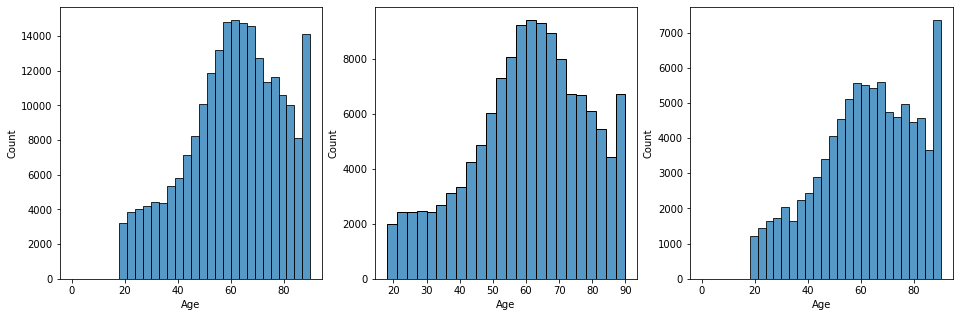

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (16, 5))
sns.histplot(data = df, x = 'Age', binwidth = 3, ax = ax[0])
sns.histplot(data = df[df['Sex'] == 'Male'], x = 'Age', binwidth = 3, ax = ax[1])
sns.histplot(data = df[df['Sex'] == 'Female'], x = 'Age', binwidth = 3, ax = ax[2])

Widzimy, że rozkład wieku dla poszczególnych płci jest podobny.
Wątpliwości wzbudza jednak nienaturalnie wysoka wartość ostatniego słupka, a także brak wartości poniżej 18 (w sytuacji, gdy wyżej sprawdziliśmy, że minimalny wiek to zero).

In [8]:
df['Age'].value_counts().sort_index()

0        3
18     766
19    1167
20    1287
21    1279
      ... 
86    2384
87    2357
88    2140
89    2024
90    7579
Name: Age, Length: 74, dtype: int64

Informacja o 3 osobach w wieku poniżej 1. roku życia jest zgodna z informacjami podanymi w artykule. Natomiast co do wieku $90$, to wydaje się niemal pewne, że w rzeczywistości oznacza on $\geqslant 90$ - jest to usterka, o której należy pamiętać podczas dalszej pracy z tym zbiorem.

#### Pozostałe kolumny (od `No Finding` do `Support Devices`)

Kolumny te, zgodnie z informacjami podanymi w artykule, zawierają informację dot. poszczególnych chorób (1 oznacza stwierdzenie choroby, 0 jej brak, -1 wynik niepewny, poza tym występują braki danych `nan`), ich braku oraz urządzeniach wspierających.

In [9]:
np.unique ( df.iloc[:, 5:-1].to_numpy().flatten() )

array([-1.,  0.,  1., nan])

Sprawdzimy, czy nie występują oczywiste błędy w poniższych kolumnach, tj. czy nie występuje sytuacja, w której zmienna `No Finding` przyjmuje wartość 0, a w innej kolumnie z nazwą pewnej choroby widnieje 1.

Jak się okazuje, taka sytuacja na szczęście nie zachodzi.

In [10]:
(((df.iloc[:, 6:-2] == 1).any(axis = 1)) & (df['No Finding'] == 1)).any()

False

#### Przegląd zdjęć

Poniżej po 9 losowo wybranych zdjęć (wykonanych odpowiednio z przodu i z boku):

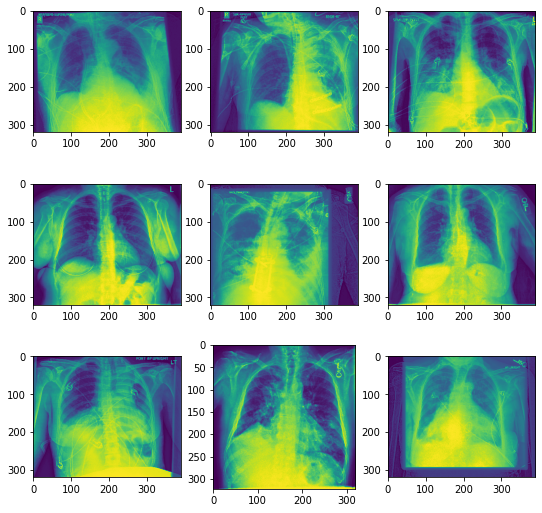

In [11]:
m, n = 3, 3
fig, axes = plt.subplots(m, n, figsize=(n * n, m * m))
for i in range(m):
    for j in range(n):
        img = mpimg.imread(src + df[df['Frontal/Lateral'] == 'Frontal']['Path'].sample().values[0])
        axes[i, j].imshow(img)

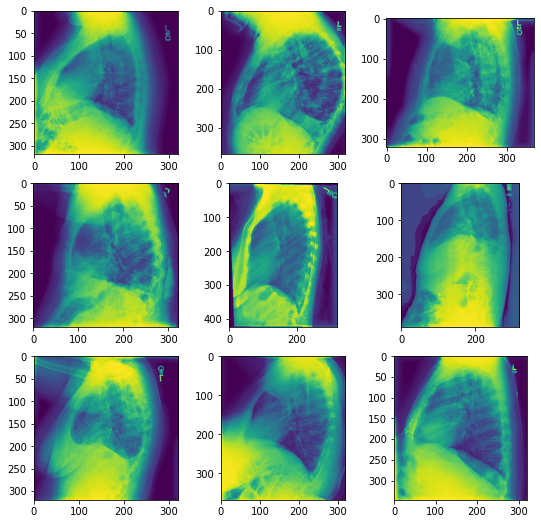

In [12]:
m, n = 3, 3
fig, axes = plt.subplots(m, n, figsize=(n * n, m * m))
for i in range(m):
    for j in range(n):
        img = mpimg.imread(src + df[df['Frontal/Lateral'] == 'Lateral']['Path'].sample().values[0])
        axes[i, j].imshow(img)

### Analiza danych opisujących zdjęcia

#### Czy dane dotyczące wykrytych chorób opisują je w sposób efektywny? Jak zastąpić braki danych?

Poniżej przedstawiono procentowy odsetek poszczególnych wartości w kolumnach opisujących, czy pacjent zachorował na daną chorobę.

In [13]:
pd.Series(df.iloc[:, 5:-1].to_numpy().flatten()).value_counts(dropna = False, normalize = True).to_frame(name = 'rate')

,rate
NaN,0.728300
1.0,0.164841
0.0,0.062112
-1.0,0.044747


oraz ten sam odsetek z podziałem na poszczególne kolumny:

In [14]:
df.iloc[:, 5:-1].apply(lambda x: x.value_counts(normalize = True, dropna = False), axis = 0).fillna(0).round(3)

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
-1.0,0.0,0.056,0.036,0.025,0.007,0.058,0.124,0.084,0.151,0.014,0.052,0.012,0.003,0.005
0.0,0.0,0.097,0.050,0.030,0.006,0.093,0.126,0.013,0.006,0.252,0.158,0.001,0.011,0.027
1.0,0.1,0.048,0.121,0.473,0.041,0.234,0.066,0.027,0.149,0.087,0.386,0.016,0.040,0.519
NaN,0.9,0.799,0.793,0.473,0.947,0.615,0.684,0.876,0.694,0.647,0.404,0.971,0.945,0.448


Dane te są niskiej jakości.

Po pierwsze dlatego, że wynik pozytywny oznaczony jest przez 1, zaś negatywny i nierozstrzygający - odpowiednio przez 0 i -1. W efekcie algorytmy uczenia maszynowego będą rozpoznawały wyniki nierozstrzygające jako "bardziej negatywne" niż te, które na pewno są negatywne. Zasadna jest zatem zmiana wartości -1 np. na 0.5.

Po drugie, występuje sporo braków danych - ponad 70% wszystkich pól. Gdyby owe braki były zdeterminowane losowo, to oczywistym pomysłem byłoby zastąpienie ich np. średnią. Jednak znacznie bardziej prawdopodobne wydaje się, że w wielu badaniach po prostu z góry przyjęto założenie o niewypełnianiu określonych kolumn. Popatrzmy na liczbę poszczególnych wierszy, pogrupowanych ze względu na podzbiór kolumn, w których wystąpił brak danych:

In [15]:
(~(df.iloc[:, 5:-1].isna())).apply(list, axis = 1).value_counts().head(20)

[False, False, False, True, False, False, False, False, False, False, True, False, False, True]      5779
[False, False, False, True, False, True, False, False, False, False, True, False, False, True]       4772
[False, False, False, True, False, False, False, False, False, True, True, False, False, True]       4253
[True, False, False, False, False, False, False, False, False, True, False, False, False, True]      3381
[False, False, False, True, False, False, False, False, False, True, False, False, False, True]      3295
[False, False, False, False, False, False, False, False, False, True, False, False, False, True]     2650
[False, False, False, True, False, True, False, False, False, False, False, False, False, True]      2484
[False, False, False, True, False, False, False, False, False, False, True, False, False, False]     2339
[False, False, False, False, False, True, False, False, False, False, False, False, False, True]     2255
[False, False, True, True, False, True, False,

Zbiór danych liczy niespełna 250 tysięcy wierszy. Gdyby braki danych występowały losowo, to byłoby ich dużo mniej, a każdy podzbiór wystąpiłby maksymalnie około $\frac{223414}{2^{14}} \approx 13.6$ razy. Niektóre kombinacje występują jednak dużo częściej i nasuwa się wniosek (zwłaszcza, gdy weźmiemy pod uwagę długi okres zbierania danych), że w określonych badaniach wypełniano tylko ograniczony zbiór kolumn - np. w pewnych 4253 badaniach (z 223414, co stanowi ok. 2%) uzupełniano tylko `Lung Opacity`, `Pneumothorax`, `Pleural Effusion`, `Fracture` i `Support Devices`, a innych chorób po prostu nie rozważano. 

Ostatecznie zatem najlepszym rozwiązaniem wydaje się zamiana wartości -1 na 0.5 oraz uzupełnienie braków danych liczbą 0.

In [16]:
df_num = df.copy()
df_num.iloc[:, 5:-1] = df_num.iloc[:, 5:-1].replace(-1, 0.5).fillna(0)
df_num.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,00001
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,0.5,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,1.0,0.0,00002
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,00002
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,00002
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00003


#### Jak wartość zmiennej `Age` może wpłynąć na wynik działania algorytmu?

W celu odpowiedzi na powyższe pytanie najpierw podzielimy użytkowników na 5 równych grup, w zależności od wieku.

In [17]:
ages_qcut = pd.qcut(df_num['Age'], np.arange(0, 1.01, 1/5))
ages_qcut.value_counts(normalize = True)

(45.0, 57.0]      0.204455
(66.0, 77.0]      0.202297
(-0.001, 45.0]    0.201814
(57.0, 66.0]      0.199831
(77.0, 90.0]      0.191604
Name: Age, dtype: float64

Następnie sprawdzimy, w jakich grupach wiekowych najczęściej rozpoznawana była dana choroba (wartość 1).

In [18]:
diseases_by_age = pd.concat([ages_qcut[df_num[cname]==1].value_counts(normalize=True) for cname in df_num.columns[5:-1]], axis = 1)
diseases_by_age.columns = df_num.columns[5:-1]
diseases_by_age

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
"(-0.001, 45.0]",0.380412,0.202908,0.153074,0.170495,0.166776,0.139838,0.192518,0.202517,0.168235,0.264706,0.150823,0.200681,0.201991,0.203490
"(45.0, 57.0]",0.247531,0.193091,0.174815,0.192355,0.200958,0.189392,0.185619,0.176188,0.210780,0.198169,0.193649,0.175135,0.200111,0.216714
"(57.0, 66.0]",0.172423,0.201982,0.187778,0.204061,0.199978,0.199537,0.201921,0.183308,0.211559,0.215086,0.210681,0.202100,0.182854,0.213912
"(66.0, 77.0]",0.124704,0.209576,0.209259,0.216014,0.236338,0.225434,0.215585,0.197052,0.219110,0.199815,0.226043,0.205223,0.184181,0.203102
"(77.0, 90.0]",0.074930,0.192443,0.275074,0.217075,0.195950,0.245799,0.204356,0.240934,0.190316,0.122223,0.218803,0.216861,0.230863,0.162783


W niemal każdym przypadku mamy wyniki także zbliżone do 20%, co sugeruje, że wiek nie ma wpływu na częstość występowania danej choroby. Jedynie w przypadku `No Finding` wartość 1 znacznie częściej pojawiała się w młodszych rocznikach, aniżeli w starszych. Oznacza to, iż zmienna `Age` może zaburzyć wynik działania algorytmu, zbyt często błędnie wskazując wartość 1 w `No Finding`. Zasadne wydaje się zatem usunięcie kolumny `No Finding` - tym bardziej, że nie niesie ona żadnych istotnych informacji (jak wyżej stwierdziliśmy, brak danych będziemy uznawać za brak choroby, a zatem same zera są równoznaczne z "No Finding").

In [19]:
df_num = df_num.drop(columns = ['No Finding'])
df_num.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,00001
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.5,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,1.0,0.0,00002
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,00002
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,00002
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00003


#### Jak wartość zmiennej `Frontal` może wpłynąć na wynik działania algorytmu?

Wyznaczymy odsetek wystąpień poszczególnych chorób dla zdjęć wykonywanych z przodu i podzielimy przez taki sam odsetek dla zdjęć wykonywanych z tyłu.

In [20]:
frontal = df_num[df_num['Frontal/Lateral'] == 'Frontal'].iloc[:, 5:-2] == 1
lateral = df_num[df_num['Frontal/Lateral'] == 'Lateral'].iloc[:, 5:-2] == 1
((frontal.sum() / len(frontal)) / (lateral.sum() / len(lateral))).sort_values()

Pleural Other                 0.417192
Lung Lesion                   0.556185
Pneumonia                     0.581090
Fracture                      0.785979
Enlarged Cardiomediastinum    0.966839
Cardiomegaly                  1.096743
Consolidation                 1.222865
Atelectasis                   1.378220
Pleural Effusion              1.403700
Lung Opacity                  1.404808
Pneumothorax                  1.709229
Edema                         3.275758
dtype: float64

Widzimy zatem, że prawdopodobieństwo stwierdzenia określonych chorób w większości przypadków jest uzależnione od tego, jak wykonywane było badanie.

#### Czy wystąpienie jednej choroby ma wpływ na ryzyko wystąpienia innej?

Występowanie poszczególnych chorób w całym zbiorze danych:

In [21]:
diseases = (df_num.iloc[:, 5:-2] == 1).sum()
diseases = diseases / df_num.shape[0]
diseases

Enlarged Cardiomediastinum    0.048332
Cardiomegaly                  0.120852
Lung Opacity                  0.472580
Lung Lesion                   0.041116
Edema                         0.233853
Consolidation                 0.066169
Pneumonia                     0.027031
Atelectasis                   0.149391
Pneumothorax                  0.087049
Pleural Effusion              0.385773
Pleural Other                 0.015769
Fracture                      0.040463
dtype: float64

Występowanie choroby $W$ (wiersze) w populacji rekordów ze stwierdzoną chorobą $K$ (kolumny):

In [22]:
dnames = list(df_num.columns[5:-2])
diseases_pairs = pd.DataFrame(columns = dnames, index = dnames)
for i in range(len(dnames)):
    for j in range(len(dnames)):
        diseases_pairs.loc[dnames[i], dnames[j]] = len(df_num[(df_num[dnames[i]] == 1) & (df_num[dnames[j]] == 1)]) / len(df_num[df_num[dnames[j]] == 1])
diseases_pairs = diseases_pairs.astype('float')
diseases_pairs

,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture
Enlarged Cardiomediastinum,1.000000,0.070407,0.048304,0.055410,0.040750,0.039572,0.024839,0.044673,0.039747,0.045111,0.054783,0.070465
Cardiomegaly,0.176051,1.000000,0.123592,0.067821,0.223156,0.097139,0.081967,0.114693,0.039953,0.137329,0.092251,0.088606
Lung Opacity,0.472310,0.483296,1.000000,0.578707,0.525495,0.377055,0.666501,0.423837,0.466012,0.605637,0.533352,0.399447
Lung Lesion,0.047138,0.023074,0.050350,1.000000,0.016575,0.050599,0.075178,0.030711,0.044529,0.037883,0.087993,0.037942
Edema,0.197166,0.431815,0.260037,0.094274,1.000000,0.213353,0.199371,0.264981,0.076049,0.307715,0.086290,0.111615
Consolidation,0.054177,0.053185,0.052794,0.081428,0.060368,1.000000,0.167909,0.060013,0.037999,0.085895,0.085155,0.044358
Pneumonia,0.013891,0.018333,0.038122,0.049423,0.023045,0.068592,1.000000,0.018426,0.007507,0.020107,0.034913,0.015597
Atelectasis,0.138081,0.141778,0.133982,0.111583,0.169276,0.135493,0.101838,1.000000,0.160993,0.189008,0.110417,0.141704
Pneumothorax,0.071587,0.028778,0.085839,0.094274,0.028308,0.049990,0.024176,0.093810,1.000000,0.077634,0.071814,0.116150
Pleural Effusion,0.360067,0.438370,0.494388,0.355432,0.507618,0.500778,0.286968,0.488075,0.344046,1.000000,0.261141,0.271681


<AxesSubplot:>

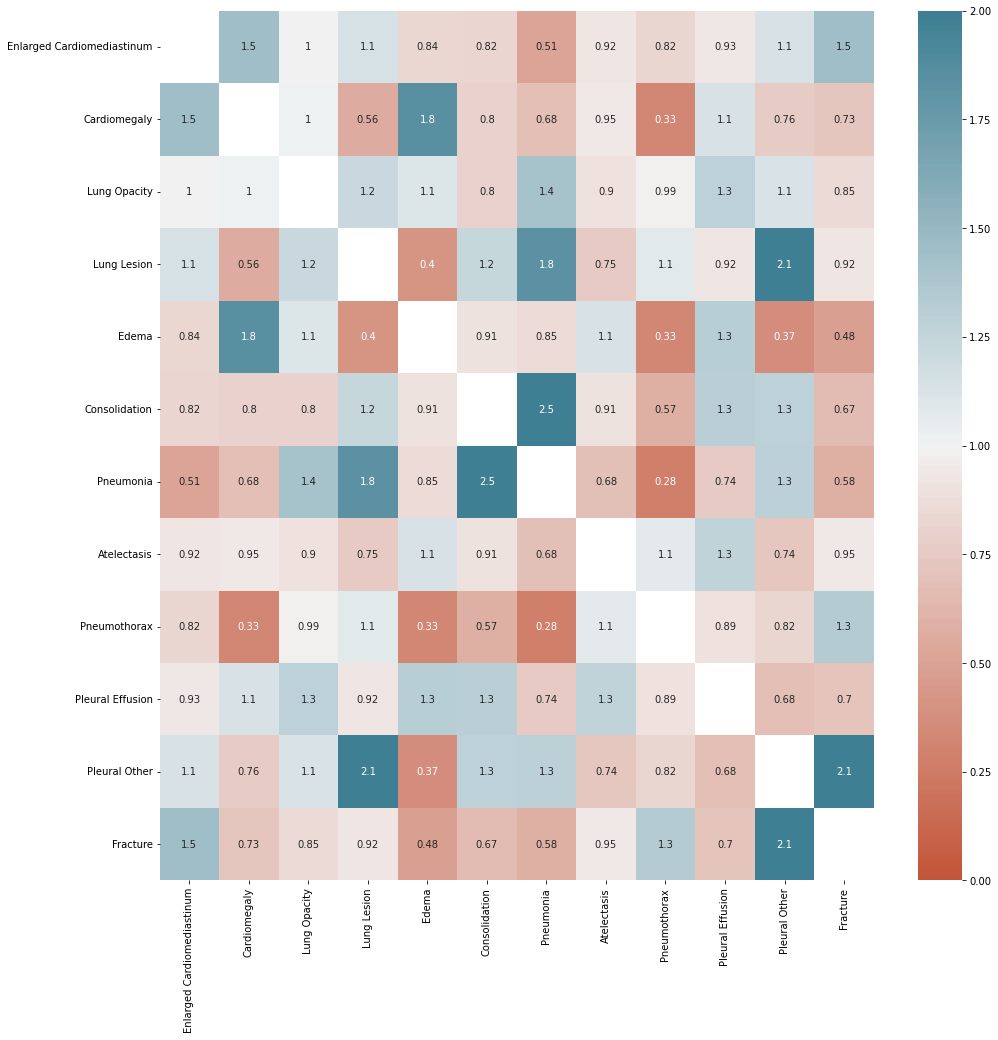

In [23]:
ratio = (diseases_pairs / np.tile(diseases.values[:, np.newaxis], len(dnames))).transpose()
plt.figure(figsize = (16,16))
sns.heatmap(ratio, mask = np.tril(ratio) * np.triu(ratio),
    annot=True,
    cmap=sns.diverging_palette(20, 220, n=200),
    vmin=0, vmax=2, center=1)

Widzimy zatem, że w wielu przypadkach jedne choroby zwiększają/zmniejszają prawdopodobieństwo stwierdzenia innych. Na przykład zapalenie płuc (Pneumonia) zwiększa 2,5-krotnie prawdopodobieństwo, że wystąpi konsolidacja (Consolidation), albowiem wśród wszystkich rekordów konsolidacja występowała z częstością 0.066169, ale wśród rekordów zawierających stwierdzone zapalenie płuc - już z częstością 0.167909.

### Wnioski z przeprowadzonej analizy:

* kolumna `No Finding` okazała się zbędna
* dane dotyczące chorób są słabej jakości, ale okazały się łatwo poprawialne
* dane dotyczące wieku u najstarszych osób (90+) są niedokładne
* sposób wykonania zdjęcia wpływa na prawdopodobieństwo stwierdzenia poszczególnych chorób lub ich braku
* choroby są częściowo powiązane ze sobą, tj. w wielu przypadkach fakt wystąpienia jednej choroby zwiększa prawdopodobieństwo wystąpienia innej.

## Zbiór danych ChinaSet (tekstowy)

### Załadowanie zbioru danych

In [24]:
src2 = "D:/wb/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/"

In [25]:
content = []
for (dirpath, dirnames, filenames) in os.walk(src2):
    filenames = filenames
for filename in filenames:
    with open(src2 + filename, mode = 'r') as f:
        content.append([filename.split('_')[1], f.read()])
df2 = pd.DataFrame(content, columns = ['id', 'content'])
df2['content'] = df2['content'].str.lower()
df2

,id,content
0,0001,male 45yrs\nnormal
1,0002,male 63yrs\nnormal
2,0003,female 48yrs\nnormal
3,0004,male 58yrs \nnormal
4,0005,male 28yrs\nnormal
...,...,...
657,0658,male 41yrs \t\nbilateral secondary ptb with ...
658,0659,"male , 33yrs \t\nsecondary ptb in the left u..."
659,0660,"male , 50yrs \t\n1.bilateral secondary ptb w..."
660,0661,"male, 26yrs \t\nbilateral secondary ptb with..."


### Płeć pacjentów

In [26]:
df2[~(df2['content'].str.contains('male'))]

,id,content
43,0044,femal 32yrs\nnormal\n
44,0045,femal 60yrs\n\nnormal
95,0096,femal 69yrs\nnormal


Poprawiamy błędnie uzupełnione rekordy:

In [27]:
df2['content'] = df2['content'].str.replace('femal ', 'female ')

Liczba pacjentów poszczególnej płci:

In [28]:
print(f"Female: {df2['content'].str.contains('female').sum()}")
print(f"Male: {(~(df2['content'].str.contains('female')) & df2['content'].str.contains('male')).sum()}")


Female: 213
Male: 449


### Wiek pacjentów

<AxesSubplot:xlabel='content', ylabel='Count'>

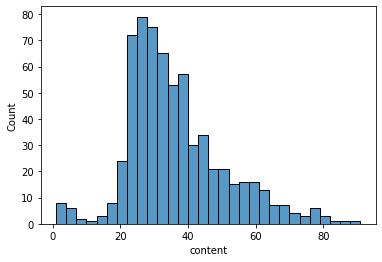

In [29]:
def yrs_to_int(yrs):
    if type(yrs) != type([]): return np.nan
    if len(yrs) == 0: return np.nan
    return yrs[0].replace('yrs', '')

ages = df2['content'].str.findall(r"[0-9]*yrs").apply(yrs_to_int).dropna()
ages = ages[ages != ""].astype('int')
sns.histplot(data = ages, binwidth = 3)

In [30]:
pd.DataFrame([
    list(elem) for elem in Counter(" ".join(df2['content'].str.split("\n", n = 1).apply(lambda x: x[1])).split()).most_common(1000)
], columns = ['word', 'count']).head(25)

,word,count
0,normal,325
1,ptb,296
2,right,138
3,bilateral,123
4,upper,117
5,in,113
6,the,110
7,field,106
8,secondary,83
9,left,70


Najczęściej występujące słowo to *normal* - ponad 325 razy, a zatem w około połowie badań nie wykryto żadnej choroby. Kolejne istotne, a powtarzające się wyrazy to PTB (pulmonary tuberculosis) - gruźlica płuc, pleural - opłucny, effusion - wylew. Większość wyrazów stanowią słowa charakterystyczne dla języka angielskiego.

### Wnioski:

* niewielki zbiór danych
* mała liczba często powtarzających się terminów medycznych
* trudno wyciągnąć określone wnioski, raczej nieprzydatny do dalszej eksploracji.